# 3. Creating and Evaluating Forecasts

In this script, we will begin by introducing the evaluation metrics employed to assess the performance of our forecasting model. Subsequently, we will refine the trained DeepAR model by establishing an optimal classification threshold and then proceed to predict device usage during the testing period.

## 1. Load Data

In [1]:
devices = {0: {'hh': 'hh1', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          1: {'hh': 'hh1', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          2: {'hh': 'hh2', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          3: {'hh': 'hh2', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          4: {'hh': 'hh3', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          5: {'hh': 'hh3', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          6: {'hh': 'hh3', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          7: {'hh': 'hh4', 'dev_name': 'Washing Machine (1)', 'dev': 'washing_machine'},
          8: {'hh': 'hh4', 'dev_name': 'Washing Machine (2)', 'dev': 'washing_machine'},
          9: {'hh': 'hh5', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          10: {'hh': 'hh6', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          11: {'hh': 'hh6', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          12: {'hh': 'hh7', 'dev_name': 'Tumble Dryer', 'dev': 'tumble_dryer'},
          13: {'hh': 'hh7', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          14: {'hh': 'hh7', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          15: {'hh': 'hh8', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          16: {'hh': 'hh9', 'dev_name': 'Washer Dryer', 'dev': 'washer_dryer'},
          17: {'hh': 'hh9', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          18: {'hh': 'hh9', 'dev_name': 'Dishwasher', 'dev': 'dishwasher'},
          19: {'hh': 'hh10', 'dev_name': 'Washing Machine', 'dev': 'washing_machine'},
          }



In [2]:
import pandas as pd
import numpy as np
import os

PICKLE_PATH = os.getcwd()+'/data/pickle_files'


## 2. Create Evaluation Metrics

The **'Evaluation_Metrics'** class equips us with the evaluation metrics we will use for assessing the performance of our binary forecasting model. These metrics provide a comprehensive understanding of how well our predictions align with actual outcomes. 

Moreover, we will investigate the implications of introducing a 2-hour tolerance window specifically for the minority class. Given that device usage accounts for only about 6% of the data, we find it particularly interesting to examine metrics when allowing for a small error margin. This analysis will offer valuable insights into model performance, especially in scenarios where small deviations are permissible for the minority class.


### 2.1 Initialize the Class

First, the class is initialized with the forecast and target data, along with devices which contains device specific information.

In [3]:
from typing import Dict, List, Any, Tuple
class Evaluation_Metrics:
    '''
    A class for evaluating binary forecasts against target data.
    It calculates various metrics including misclassification error, accuracy, precision,
    recall, and F1-score for binary forecasts at both hourly and daily levels.
    Parameters:
    ----------
    forecast
        A dictionary of forecasted dataframes for each device
    target
        A dictionary of target dataframes for each device
    devices
        A dictionary containing device-specific information
    '''
    def __init__(
        self,
        forecast: Dict[str, pd.DataFrame],
        target: Dict[str, pd.DataFrame],
        devices: Dict[str, Any],

    ):
        self.forecast =  {dev: df.copy() for dev, df in forecast.items()}
        self.target = {dev: df.copy() for dev, df in target.items()} 
        self.date_list = np.unique(next(iter(self.target.values())).index.date)
        self.devices = devices


### 2.2 Introducing tolerance

Before moving onto the evaluation metrics, we first introduce the **'update_forecast_with_tolerance'** method. 

Incorporating a tolerance window in evaluating the DeepAR model aims to account for the complexities posed by highly unbalanced data distributions, where only about 6% of the dataset represents positive outcomes, and the remaining 94% is dominated by negative instances. By introducing a 2-hour tolerance window around the actual usage instances, we relax the evaluation conditions and allow for a margin of error. This helps us gain a deeper understanding of the model's capability to anticipate device usage patterns.

In the method below, when a positive prediction is encountered for a device, the function adjusts adjacent time points to also be predicted as positive. We then use this adjusted forecast to calculate false positives. By increasing the number of positive predictions, we achieve higher true positive and false negative rates. We can use this adjusted forecast to compute more relatex error and accuracy metrics.

In [4]:
def update_forecast_with_tolerance(self):
    
    import copy

    arr_dict = {}

    forecast_with_tolerance = copy.deepcopy(self.forecast)

    for dev in forecast_with_tolerance.keys():
        length = len(forecast_with_tolerance[dev])

        positive_forecasts = np.where(forecast_with_tolerance[dev] == 1)[0]

        if positive_forecasts.size > 0:
            
            forecast_with_tolerance[dev].iloc[np.maximum(positive_forecasts - 1, 0)] = 1
            forecast_with_tolerance[dev].iloc[np.maximum(positive_forecasts - 2, 0)] = 1
            forecast_with_tolerance[dev].iloc[np.minimum(positive_forecasts + 1, length - 1)] = 1
            forecast_with_tolerance[dev].iloc[np.minimum(positive_forecasts + 2, length - 1)] = 1
                
    return forecast_with_tolerance

setattr(Evaluation_Metrics, 'update_forecast_with_tolerance', update_forecast_with_tolerance)
del update_forecast_with_tolerance


### 2.3 Evaluation Metrics for Binary Classification

#### 2.3.1 Total misclassification error

**'total_misclassification_error'** method quantifies the total count of misclassifications made by a model. It is the sum of false positives and false negatives. The method takes as input the forecast and provides flexibility by allowing users to compute the metric with or without a tolerance adjustment in the forecast. The increased number of positive instances in the updated forecasts results in lower false negatives.

In [5]:
def total_misclassification_error(self, forecast):
    total_error = 0

    for dev in self.target.keys():
        FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))
        FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))

        total_error += FP + FN
    
    return total_error[0]

setattr(Evaluation_Metrics, 'total_misclassification_error', total_misclassification_error)
del total_misclassification_error


#### 2.3.2 Total daily misclassification error

**'total_daily_misclassification_error'** method quantifies the total count of misclassifications made by the model on days where there are no missing values. It considers usage misclassifications on a daily basis.

In [6]:
def total_daily_misclassification_error(self, forecast):
        
    total_daily_error = 0
    for dev in self.target.keys():
            
        daily_forecast = forecast[dev].groupby(forecast[dev].index.date).sum()
        daily_target = self.target[dev].groupby(self.target[dev].index.date).agg(lambda x: np.nan if x.isnull().any() else x.sum())
        
        daily_forecast['usage'] = daily_forecast['usage'].apply(lambda x: 1 if x > 0 else 0)
        daily_target['usage'] = daily_target['usage'].apply(lambda x: 1 if (not pd.isna(x) and x > 0) else x)
            
        FP = sum((daily_forecast.values == 1) & (daily_target.values == 0))
        FN = sum((daily_forecast.values == 0) & (daily_target.values == 1))

        total_daily_error += FP + FN
    
    return total_daily_error[0]

setattr(Evaluation_Metrics, 'total_daily_misclassification_error', total_daily_misclassification_error)
del total_daily_misclassification_error


#### 2.3.3 Hourly Accuracy

**'hourly_accuracy'** method measures the proportion of correctly predicted outcomes, both positive and negative, compared to the total number of instances in the dataset. It provides a simple and intuitive way to understand how well a model's predictions align with actual observations.

In [7]:
def hourly_accuracy(self, forecast):
    x = self.total_misclassification_error(forecast)
        
    sum_notna_hours = 0
    for i in self.target.keys():
        sum_notna_hours += self.target[i].notna().sum()[0]
        
    accuracy = 1 - x / sum_notna_hours
    return round(accuracy,3)
    
setattr(Evaluation_Metrics, 'hourly_accuracy', hourly_accuracy)
del hourly_accuracy


#### 2.3.4 Daily Accuracy

The **'daily_accuracy'** calculates the proportion of correctly predicted daily usage, factoring in both positive and negative predictions, in comparison to the total number of non-NA containing days in the dataset.

We will use this metric to define the classification threshold of the probabilistic forecasting outcomes.

In [8]:
def daily_accuracy(self, forecast):
    tme_daily = self.total_daily_misclassification_error(forecast)
        
    sum_notna_days = 0

    for i in self.target.keys():
        daily_target = self.target[i].groupby(self.target[i].index.date).agg(lambda x: np.nan if x.isnull().any() else x.sum())
        sum_notna_days += daily_target.notna().sum()
        
    accuracy = (1 - tme_daily / sum_notna_days)[0]
    return round(accuracy,3)
    
setattr(Evaluation_Metrics, 'daily_accuracy', daily_accuracy)
del daily_accuracy


#### 2.3.5 Precision

Precision measures the model's ability to make accurate positive predictions, minimizing the occurrences of false positive errors. It quantifies the ratio of correctly identified positive instances to the total instances predicted as positive. A high precision score signifies that when the model predicts a positive outcome, it is generally reliable and trustworthy.

In [9]:
def precision(self,forecast):
    
    total_precision = 0
    
    for dev in self.target.keys():

        if forecast[dev].sum()[0] == len(forecast[dev]):
            FP = sum((forecast[dev].values == 1) & (self.target[dev].values == 0))
            
        else:
            FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))

        TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))   
            
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        total_precision += precision
        
    average_precision = total_precision[0]/len(self.devices)

    return round(average_precision,3)

setattr(Evaluation_Metrics, 'precision', precision)
del precision


#### 2.5.6 Recall

Recall assesses a model's ability to capture all positive instances within the dataset. It quantifies the ratio of correctly identified positive instances to the total number of actual positive instances. It emphasizes the model's sensitivity to accurately recognizing true positives. High recall is valuable when missing positive instances carries significant consequences, as it ensures a higher likelihood of identifying most of them. 

In [10]:
def recall(self,forecast):
    
    total_recall = 0
    
    for dev in self.target.keys():
        
        TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))
        FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        total_recall += recall
    
    average_recall = total_recall[0]/len(self.devices)

    return round(average_recall,3)

setattr(Evaluation_Metrics, 'recall', recall)
del recall


#### 2.5.7 F1 Score

The F1 score offers comprehensive assessment of a model's classification performance by balancing precision and recall. The F1 score is beneficial when there's a need to strike a balance between precision and recall, for situations where both false positives and false negatives have significant implications.





In [11]:
def f1_score(self,forecast):
    
    total_f1_score = 0
    
    for dev in self.target.keys():
        
        TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))
        FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))
        FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        if precision == 0 and recall == 0:
            f1_score =  0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
            
        total_f1_score += f1_score
        
    average_f1_score = total_f1_score[0]/len(self.devices)  
    
    return round(average_f1_score,3)

setattr(Evaluation_Metrics, 'f1_score', f1_score)
del f1_score


## 3. Creating Forecasts for the Testing Period

Now that we have our evaluation metrics at hand, we can move on to using our trained model to create predictions.

### 3.1 Initialize the Class

We introduce the **'Generate_Forecasts'** class, that enables the creation of finely tuned probabilistic forecasts from forecast samples.

In [12]:
from helper_functions_thesis import Helper_Functions_Thesis

load_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'load_dict.pickle')
activity_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'activity_dict.pickle')
usage_dict = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH, 'usage_dict.pickle')
predictor = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'deepar_model.pickle')

In [13]:
start_dataset = '2014-03-01'
end_dataset = '2015-05-07'

from Thesis_Classes import Create_Dataset
create_dataset = Create_Dataset(start_dataset, end_dataset, devices, load_dict, usage_dict, activity_dict)
dataset_dict = create_dataset.pipeline()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [14]:
val_start = '2015-01-01'
val_length = 31
num_samples = 1000

target_val = Helper_Functions_Thesis.create_target_values(
    val_start, val_length, dataset_dict, binary_usage=True)


In [15]:
class Generate_Forecasts:
    '''
    A class for generating forecasts using a specified DeepAR predictor model.
    Parameters:
    ----------
    start_dataset :
        The starting date of the dataset used for training the predictor.
    start_forecast :
        The start date of the forecasting period in 'yyyy-mm-dd' format.
    length_forecast :
        The length of the forecasting period in days.
    predictor :
        The machine learning model used for making forecasts.
    num_samples :
        The number of samples to generate for each device's forecast.
    devices :
        A dictionary containing device-specific information.
    target :
        The target variable for the forecasts.
    dataset_dict :
        A dictionary with target time series data along with covariates.
    '''
    def __init__(
        self,
        start_dataset,
        start_forecast,
        length_forecast,
        predictor,
        num_samples,
        devices,
        target,
        dataset_dict
    ):
        from helper_functions_thesis import Helper_Functions_Thesis
        self.start_dataset = start_dataset
        self.date_list_daily = Helper_Functions_Thesis.create_date_list_daily(start_forecast, length_forecast)
        self.date_list_hourly = Helper_Functions_Thesis.create_date_list_hourly(start_forecast, length_forecast)
        self.predictor = predictor
        self.num_samples = num_samples
        self.devices = devices
        self.target = target
        self.dataset_dict = dataset_dict

In [16]:
generate_forecasts_val = Generate_Forecasts(
    start_dataset,
    val_start,
    val_length,    
    predictor,
    num_samples,
    devices,
    target_val,
    dataset_dict)

### 3.2 Create Forecast Samples

With the DeepAR model, first step to create forecasts is to create forecast samples. When using this model to predict a time series, the output of the model is represented in a SampleForecast class, which provides samples of the predicted values along with additional information such as the start date, frequency and the prediction length. 

To assess the model's stability, we seek to generate forecasts for a validation period of 31 days and a testing period of 96 days. To accomplish this, we implement the **'create_forecast_samples'** method. This method creates and combines forecast samples to create a comprehensive dictionary spanning through the prediction phase.

In [17]:
def create_forecast_samples(self):
    
    from Thesis_Classes import Transform_Dataset
    from datetime import timedelta
    from gluonts.evaluation.backtest import make_evaluation_predictions
    
    forecasts = {}

    for day, date in enumerate(self.date_list_daily):

        transformer = Transform_Dataset(start_training = self.start_dataset, 
                                        start_validation = date, 
                                        devices = self.devices, 
                                        dataset_dict = self.dataset_dict)
        
        _, _, test_ds = transformer.pipeline()

        forecast_deepar, _ = make_evaluation_predictions(
            dataset=test_ds,
            predictor=self.predictor,
            num_samples=self.num_samples
        )
        
        forecast = list(forecast_deepar)
        
        forecast_dict = {}
        for i, device_key in enumerate(self.devices.keys()):
            forecast_dict[device_key] = forecast[i]

        forecasts[day] = forecast_dict
        
    return forecasts

setattr(Generate_Forecasts, 'create_forecast_samples', create_forecast_samples)
del create_forecast_samples


In [18]:
#forecast_samples_val = generate_forecasts_val.create_forecast_samples()
forecast_samples_val = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'forecast_samples_val.pickle')

### 3.3 Create Forecast Lists

The baseline method employed by DeepAR for outcome classification relies on the sample median. Although the model doesn't inherently produce direct probabilities for binary outcomes, it offers the flexibility to create a custom function for outcome determination, predicated on a user-defined quantile. Raising this quantile value is akin to reducing the classification threshold and affects how prediction results are categorized. We manipulate this threshold to increase daily accuracy.

The **'create_forecast_lists'** method, featured in this context, operates on forecasted samples alongside a specified threshold value to determine model outcomes, decisively categorizing them as either 0 or 1.

In [19]:
def create_forecast_lists(self, forecasts, threshold=0.5):
    forecasts_list = {}
    quantile = 1-threshold
    
    for i in self.devices.keys():
        forecasts_list[i] = pd.DataFrame()
        
        for date in forecasts.keys():
            quantile_forecast = np.quantile(forecasts[date][i].samples, quantile, axis=0)
            quantile_df = pd.DataFrame(quantile_forecast.astype(int))
            forecasts_list[i] = pd.concat([forecasts_list[i], quantile_df])
        
        forecasts_list[i].index = self.date_list_hourly
        forecasts_list[i].columns = ['usage']

    return forecasts_list

setattr(Generate_Forecasts, 'create_forecast_lists', create_forecast_lists)
del create_forecast_lists


### 3.4 Evaluate Forecast Samples

Now we examine a wide range of threshold values to optimize the performance of our model in the validation period. The goal is to identify the ideal threshold that minimizes total daily missclassification errors. 

With the **'evaluate_forecast_samples'** method, we examine a wide range of threshold values using the **'create_forecast_lists'** method to optimize the performance of our model. The goal is to identify the ideal threshold that minimizes total daily missclassification errors. 

In [20]:
def evaluate_forecast_samples(self, forecast_samples, metric_name):

    supported_metrics = [
        'total_misclassification_error',
        'total_daily_misclassification_error',
        'hourly_accuracy',
        'daily_accuracy',
        'precision',
        'recall',
        'f1_score'
    ]

    if metric_name not in supported_metrics:
        raise ValueError(f"Unsupported metric '{metric_name}'. Please choose a metric from the list: {supported_metrics}")

    metric_values = []
    thresholds = np.arange(0, 1, 0.01)

    for threshold in thresholds:
        forecast = self.create_forecast_lists(forecast_samples, threshold)
        metrics = Evaluation_Metrics(forecast, self.target, self.devices)
        metric_function = getattr(metrics, metric_name)
        metric_result = metric_function(forecast)
        metric_values.append(metric_result)
        
    if metric_name in ['total_misclassification_error', 'total_daily_misclassification_error']:
        best_metric_result = min(metric_values)
    else:
        best_metric_result = max(metric_values)
    
    best_threshold_idx = metric_values.index(best_metric_result)
    best_threshold = thresholds[best_threshold_idx]

    return metric_values, best_threshold, best_threshold_idx

setattr(Generate_Forecasts, 'evaluate_forecast_samples', evaluate_forecast_samples)
del evaluate_forecast_samples


We select the threshold that minimizes total daily misclassification errors.

In [22]:
TME, Threshold_TME, Threshold_TME_index = generate_forecasts_val.evaluate_forecast_samples(
    forecast_samples_val, 'total_misclassification_error')
daily_accuracy, Threshold_daily_accuracy, Threshold_daily_accuracy_index = generate_forecasts_val.evaluate_forecast_samples(
    forecast_samples_val, 'daily_accuracy')

In [23]:
forecast_val = generate_forecasts_val.create_forecast_lists(forecast_samples_val,Threshold_daily_accuracy)
evaluation_metrics = Evaluation_Metrics(forecast_val,target_val,devices)

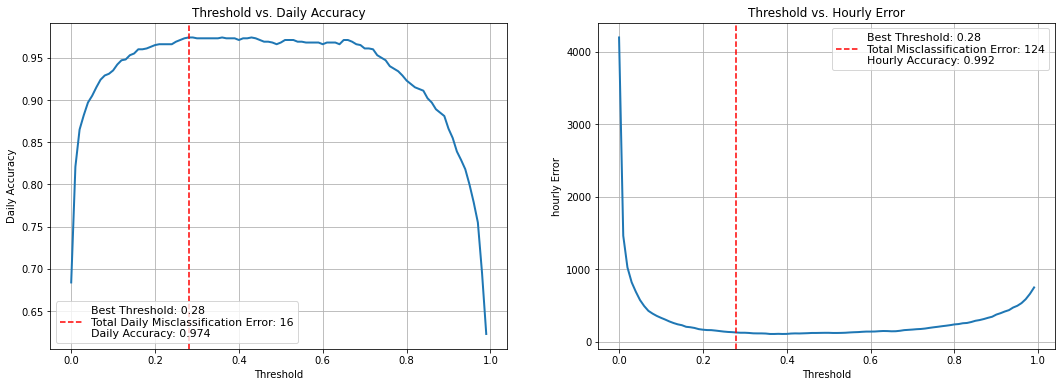

In [25]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
thresholds = np.arange(0, 1, 0.01)

TME_daily_best = evaluation_metrics.total_daily_misclassification_error(forecast_val)
daily_accuracy_best = evaluation_metrics.daily_accuracy(forecast_val)
hourly_accuracy_best = evaluation_metrics.hourly_accuracy(forecast_val)

axs[0].plot(thresholds, daily_accuracy, linestyle='-',  linewidth=2)
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Daily Accuracy')
axs[0].set_title('Threshold vs. Daily Accuracy')
axs[0].grid(True)
axs[0].axvline(x=Threshold_daily_accuracy, color='r', linestyle='--',
               label=f'Best Threshold: {Threshold_daily_accuracy} \nTotal Daily Misclassification Error: {TME_daily_best}\nDaily Accuracy: {daily_accuracy_best}')
axs[0].legend(fontsize=11)

# Create the graph
axs[1].plot(thresholds, TME, linestyle='-',  linewidth=2)
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('hourly Error')
axs[1].set_title('Threshold vs. Hourly Error')
axs[1].axvline(x=Threshold_daily_accuracy, color='r', linestyle='--',
               label=f'Best Threshold: {Threshold_daily_accuracy} \nTotal Misclassification Error: {TME[Threshold_daily_accuracy_index]}\nHourly Accuracy: {hourly_accuracy_best}')

axs[1].legend(fontsize=11)
axs[1].grid(True)
plt.savefig('daily_accuracy.png')



In [24]:
print('hourly accuracy:', evaluation_metrics.hourly_accuracy(forecast_val))
print('daily accuracy:', evaluation_metrics.daily_accuracy(forecast_val))
print('precision:',evaluation_metrics.precision(forecast_val))
print('recall:',evaluation_metrics.recall(forecast_val))
print('f1 score:',evaluation_metrics.f1_score(forecast_val))


hourly accuracy: 0.992
daily accuracy: 0.974
precision: 0.864
recall: 0.925
f1 score: 0.891


### 3.5 Create Forecasts For the Test Period

We now know the best classification threshold and can create the list of forecasts that achieve maximum daily accuracy. We create a new instance of the **'Generate_Forecasts'** class with the updated parameters for the test data, and generate forecast samples so that we can calculate different quantiles based on the recalibrated forecasts created with the selected threshold. 

In [25]:
test_start = '2015-02-01'
test_length = 96

target_test = Helper_Functions_Thesis.create_target_values(
    test_start, test_length, dataset_dict, binary_usage=True)

In [26]:
generate_forecasts_test = Generate_Forecasts(start_dataset,
                                             test_start,
                                             test_length,
                                             predictor,
                                             num_samples,
                                             devices,
                                             target_test,
                                             dataset_dict)

In [27]:
#forecast_samples_test = generate_forecasts_test.create_forecast_samples()
forecast_samples_test = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'forecast_samples_test.pickle')

### 3.6 Rescale Forecast Samples based on the Threshold

First, we need a function to rescale the probabilities. The **'rescale_probabilities'** method is designed to rescale probabilities based on a given threshold. In summary, the function transforms input probabilities based on a given threshold, mapping them to a normalized range between 0 and 1, with an inflection point at the threshold value. After the transformation, the threshold itself becomes the new 0.5 point on the scale, with all values above and below it ranging between 0 and 0.5 or 0.5 and 1, depending on their original position relative to the threshold.

In [28]:
def rescale_probabilities(self, prob, threshold):
    if prob<=threshold:
        x = prob/(2*threshold)
    else:
        x = (prob-threshold)/(2*(1-threshold))+0.5
    return x

setattr(Generate_Forecasts, 'rescale_probabilities', rescale_probabilities)
del rescale_probabilities


Afterwards, with the **'create_shifted_probabilities'** method, we operationalize this rescaling across our entire set of forecast samples, accommodating the threshold shift. We process the binary samples for each device and date, transforming them into rescaled probabilities that reflect the adjusted decision boundary. 

In [29]:
def create_shifted_probabilities(self, samples, threshold):
    problist = {}
    for dev in self.devices.keys():
        problist[dev] = []
        for date in range(0,len(samples)):
            problist[dev] = problist[dev] + [self.rescale_probabilities(p,threshold) for p in samples[date][dev].samples.mean(axis=0)]
    return problist


setattr(Generate_Forecasts, 'create_shifted_probabilities', create_shifted_probabilities)
del create_shifted_probabilities


In [30]:
shifted_probability_list = generate_forecasts_test.create_shifted_probabilities(forecast_samples_test, Threshold_daily_accuracy)

Now that we have our new set of probabilities for each device, we can create our own samples, from which we can extract the different  quantiles corresponding to the new classification threshold to visualize the prediction intervals. With the **'rescale_forecast_samples'** method, we create an empty SampleForecast class and use the probability list to create samples. 

In [31]:
def rescale_forecast_samples(self, shifted_probability_list, forecast_samples):

    from gluonts.model.forecast import SampleForecast

    forecast_samples_rescaled = {}
    for dev in self.devices.keys():
        forecast_samples_rescaled[dev] = SampleForecast(samples=np.array([[0] * len(self.date_list_hourly)] * self.num_samples),
                                                       start_date=forecast_samples[0][dev].start_date)

        for sample in range(0,len(forecast_samples_rescaled[dev].samples)):
            forecast_samples_rescaled[dev].samples[sample] = [np.random.choice([0, 1], p=[1 - x, x]) for x in shifted_probability_list[dev]]
    
    return forecast_samples_rescaled

setattr(Generate_Forecasts, 'rescale_forecast_samples', rescale_forecast_samples)
del rescale_forecast_samples


In [32]:
#forecast_samples_rescaled = generate_forecasts_test.rescale_forecast_samples(shifted_probability_list, forecast_samples_test)
forecast_samples_rescaled = Helper_Functions_Thesis.open_pickle_file(PICKLE_PATH,'forecast_samples_rescaled.pickle')

### 3.7 Create q-quantile Forecasts

Finally, with the rescaled samples at hand, we can generate q-quantile forecasts with the **'create_forecast_quantiles'** method, which provide insights into the range of potentical outcomes.

In [33]:
def create_forecast_quantiles(self, forecast_samples, quantile = 0.5):
    forecast_quantile = {}
    for dev in forecast_samples.keys():
        forecast_quantile[dev] = pd.DataFrame(forecast_samples[dev].quantile(quantile),
                                             columns=['usage'],index=self.date_list_hourly)
        
    return forecast_quantile

setattr(Generate_Forecasts, 'create_forecast_quantiles', create_forecast_quantiles)
del create_forecast_quantiles


In [34]:
forecast = generate_forecasts_test.create_forecast_quantiles(forecast_samples_rescaled, quantile = 0.50)

## 4. Evaluation

In the concluding segment of the script, we present the results of the evaluation metrics designed to assess the performance of our forecasting model, and plot the precision recall curve to provide a model-wide evaluation. The interpretation and discussion of the results can be found on our paper.

### 4.1 Evaluation Metrics

In [35]:
evaluation_metrics = Evaluation_Metrics(forecast,target_test,devices)
forecast_with_tolerance = evaluation_metrics.update_forecast_with_tolerance()

In [36]:
print('total misclassification error:', evaluation_metrics.total_misclassification_error(forecast))
print('total misclassification error with tolerance:', evaluation_metrics.total_misclassification_error(forecast_with_tolerance),'\n')
print('daily total misclassification error:', evaluation_metrics.total_daily_misclassification_error(forecast))
print('daily total misclassification error with tolerance:', evaluation_metrics.total_daily_misclassification_error(forecast_with_tolerance))

total misclassification error: 710
total misclassification error with tolerance: 557 

daily total misclassification error: 64
daily total misclassification error with tolerance: 81


In [37]:
print('hourly accuracy:', evaluation_metrics.hourly_accuracy(forecast))
print('hourly accuracy with tolerance:', evaluation_metrics.hourly_accuracy(forecast_with_tolerance),'\n')
print('daily accuracy:', evaluation_metrics.daily_accuracy(forecast))
print('daily accuracy with tolerance:', evaluation_metrics.daily_accuracy(forecast_with_tolerance))

hourly accuracy: 0.985
hourly accuracy with tolerance: 0.988 

daily accuracy: 0.967
daily accuracy with tolerance: 0.958


In [38]:
print('precision:',evaluation_metrics.precision(forecast))
print('precision with tolerance:',evaluation_metrics.precision(forecast_with_tolerance),'\n')
print('recall:',evaluation_metrics.recall(forecast))
print('recall with tolerance:',evaluation_metrics.recall(forecast_with_tolerance),'\n')
print('f1 score:',evaluation_metrics.f1_score(forecast))
print('f1 score with tolerance:',evaluation_metrics.f1_score(forecast_with_tolerance),'\n')

precision: 0.807
precision with tolerance: 0.823 

recall: 0.842
recall with tolerance: 0.913 

f1 score: 0.823
f1 score with tolerance: 0.863 



### 4.2 Precision Recall Curve

In [39]:
Precision, Threshold_Precision, Threshold_Precision_index = generate_forecasts_test.evaluate_forecast_samples(
    forecast_samples_test, 'precision')
Recall, Threshold_Recall, Threshold_Recall_index = generate_forecasts_test.evaluate_forecast_samples(
    forecast_samples_test, 'recall')

In [40]:
minority_class_proportion = 0
for dev_forecast in forecast.values():
    minority_class_proportion += (dev_forecast.sum()/len(dev_forecast))[0]/len(forecast)

print(f'Minority Class Proportion: {minority_class_proportion:.3f}')

Minority Class Proportion: 0.061


In [41]:
from sklearn.metrics import auc

pr_auc = auc(Recall, Precision)

# Calculate AUC-PR for the "no-skill" classifier
# The "no-skill" classifier has a constant precision value equal to the proportion of the minority class
no_skill_precision = minority_class_proportion
no_skill_recall = np.linspace(0, 1, len(Precision))
pr_auc_no_skill = auc(no_skill_recall, [no_skill_precision] * len(Recall))

print(f'AUC-PR for Your Classifier: {pr_auc:.2f}')
print(f'AUC-PR for No-Skill Classifier: {pr_auc_no_skill:.2f}')

AUC-PR for Your Classifier: 0.66
AUC-PR for No-Skill Classifier: 0.06


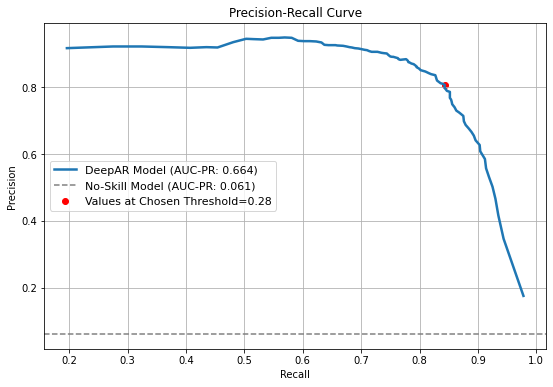

In [42]:
# Plot the Precision-Recall curve
plt.figure(figsize=(9, 6))
plt.plot(Recall, Precision, marker='', linestyle='-', linewidth=2.5,)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

from sklearn.metrics import auc, precision_recall_curve
pr_auc = auc(Recall, Precision)

highlight_precision = Precision[Threshold_daily_accuracy_index]
highlight_recall = Recall[Threshold_daily_accuracy_index]

legend_labels = [
    f'DeepAR Model (AUC-PR: {pr_auc:.3f})',
    f'No-Skill Model (AUC-PR: {pr_auc_no_skill:.3f})',
    f'Values at Chosen Threshold={Threshold_daily_accuracy:.2f}'
]

plt.axhline(y=no_skill_precision, color='gray', linestyle='--', label=legend_labels[1])
plt.scatter(highlight_recall, highlight_precision, color='red', label=legend_labels[2])
plt.legend(legend_labels, fontsize=11)

plt.grid()
plt.show()


## 5. Beyond Binary Metrics - Evaluation Measures for Forecasting Performance

The GluonTS Evaluator class offers a broader array of evaluation metrics that extend well beyond the realm of binary classification, encompassing a diverse spectrum of measures designed to comprehensively assess forecasting performance across various domains and scenarios. 
However, careful consideration is required to select and interpret the most appropriate metrics aligned with the specific binary forecasting problem at hand.

In [43]:
#We convert the target and forecast samples into lists to prepare them for evaluation by GluonTS.
import copy

forecast_samples_rescaled_list = [[]]*len(forecast_samples_rescaled)
target_list = list(copy.deepcopy(target_test).values())

for nr, dev in enumerate(devices.keys()):
    target_list[dev].index = target_list[dev].index.to_period('H')
    forecast_samples_rescaled_list[nr] = forecast_samples_rescaled[dev]

In [44]:
from gluonts.evaluation import Evaluator
quantile_seq = [0.05,0.25,0.5,0.75,0.95]
evaluator = Evaluator(quantile_seq)
agg_metrics, _ = evaluator(iter(target_list), iter(forecast_samples_rescaled_list), num_series=len(devices))

Running evaluation: 100%|██████████| 20/20 [00:00<00:00, 419.15it/s]


In [45]:
agg_metrics

{'MSE': 0.012466206336805554,
 'abs_error': 710.0,
 'abs_target_sum': 2740.0,
 'abs_target_mean': 0.059461805555555546,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 0.15840308663356967,
 'sMAPE': 0.5681300746871851,
 'MSIS': nan,
 'QuantileLoss[0.05]': 189.60000000000002,
 'Coverage[0.05]': 0.0007595486111111112,
 'QuantileLoss[0.25]': 452.5,
 'Coverage[0.25]': 0.002322048611111111,
 'QuantileLoss[0.5]': 710.0,
 'Coverage[0.5]': 0.008420138888888888,
 'QuantileLoss[0.75]': 792.0,
 'Coverage[0.75]': 0.017903645833333332,
 'QuantileLoss[0.95]': 549.4000000000002,
 'Coverage[0.95]': 0.0544921875,
 'RMSE': 0.11165216673582987,
 'NRMSE': 1.877712351528117,
 'ND': 0.2591240875912409,
 'wQuantileLoss[0.05]': 0.06919708029197082,
 'wQuantileLoss[0.25]': 0.16514598540145986,
 'wQuantileLoss[0.5]': 0.2591240875912409,
 'wQuantileLoss[0.75]': 0.28905109489051095,
 'wQuantileLoss[0.95]': 0.20051094890510957,
 'mean_absolute_QuantileLoss': 538.7,
 'mean_wQuantileLoss': 0.19660583941605841,
 'MAE_

<br>
<br>
<br>

## **Appendix A1: Complete Evaluation_Metrics Class**

In [46]:

class Evaluation_Metrics:
    '''
    A class for evaluating binary forecasts against target data.
    It calculates various metrics including misclassification error, accuracy, precision,
    recall, and F1-score for binary forecasts at both hourly and daily levels.
    Parameters:
    ----------
    forecast
        A dictionary of forecasted dataframes for each device
    target
        A dictionary of target dataframes for each device
    devices
        A dictionary containing device-specific information
    '''

    def __init__(
        self,
        forecast: Dict[str, pd.DataFrame],
        target: Dict[str, pd.DataFrame],
        devices: Dict[str, Any],

    ):
        self.forecast =  {dev: df.copy() for dev, df in forecast.items()}
        self.target = {dev: df.copy() for dev, df in target.items()} 
        self.date_list = np.unique(next(iter(self.target.values())).index.date)
        self.devices = devices

    def update_forecast_with_tolerance(self):
    
        import copy

        arr_dict = {}

        forecast_with_tolerance = copy.deepcopy(self.forecast)

        for dev in forecast_with_tolerance.keys():
            length = len(forecast_with_tolerance[dev])

            positive_forecasts = np.where(forecast_with_tolerance[dev] == 1)[0]

            if positive_forecasts.size > 0:

                forecast_with_tolerance[dev].iloc[np.maximum(positive_forecasts - 1, 0)] = 1
                forecast_with_tolerance[dev].iloc[np.maximum(positive_forecasts - 2, 0)] = 1
                forecast_with_tolerance[dev].iloc[np.minimum(positive_forecasts + 1, length - 1)] = 1
                forecast_with_tolerance[dev].iloc[np.minimum(positive_forecasts + 2, length - 1)] = 1
                
        return forecast_with_tolerance

    def total_misclassification_error(self, forecast):
        total_error = 0

        for dev in self.target.keys():
            FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))
            FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))

            total_error += FP + FN
        
        return total_error[0]

    def total_daily_misclassification_error(self, forecast):
        
        total_daily_error = 0
        for dev in self.target.keys():
                
            daily_forecast = forecast[dev].groupby(forecast[dev].index.date).sum()
            daily_target = self.target[dev].groupby(self.target[dev].index.date).agg(lambda x: np.nan if x.isnull().any() else x.sum())
            
            daily_forecast['usage'] = daily_forecast['usage'].apply(lambda x: 1 if x > 0 else 0)
            daily_target['usage'] = daily_target['usage'].apply(lambda x: 1 if (not pd.isna(x) and x > 0) else x)
                
            FP = sum((daily_forecast.values == 1) & (daily_target.values == 0))
            FN = sum((daily_forecast.values == 0) & (daily_target.values == 1))

            total_daily_error += FP + FN
        
        return total_daily_error[0]

    def hourly_accuracy(self, forecast):
        x = self.total_misclassification_error(forecast)
        
        sum_notna_hours = 0
        for i in self.target.keys():
            sum_notna_hours += self.target[i].notna().sum()[0]
        
        accuracy = 1 - x / sum_notna_hours
        return round(accuracy,3)

    def daily_accuracy(self, forecast):
        tme_daily = self.total_daily_misclassification_error(forecast)
            
        sum_notna_days = 0

        for i in self.target.keys():
            daily_target = self.target[i].groupby(self.target[i].index.date).agg(lambda x: np.nan if x.isnull().any() else x.sum())
            sum_notna_days += daily_target.notna().sum()
            
        accuracy = (1 - tme_daily / sum_notna_days)[0]
        return round(accuracy,3)

    def precision(self,forecast):
    
        total_precision = 0
        
        for dev in self.target.keys():
            
            TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))
            FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))

            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            total_precision += precision
            
        average_precision = total_precision[0]/len(self.devices)

        return round(average_precision,3)

    def recall(self,forecast):
    
        total_recall = 0
        
        for dev in self.target.keys():
            
            TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))
            FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))

            # Calculate Precision and Recall
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            total_recall += recall
        
        average_recall = total_recall[0]/len(self.devices)

        return round(average_recall,3)
        
    def f1_score(self,forecast):
    
        total_f1_score = 0
        
        for dev in self.target.keys():
            
            TP = sum((forecast[dev].values == 1) & (self.target[dev].values == 1))
            FN = sum((forecast[dev].values == 0) & (self.target[dev].values == 1))
            FP = sum((self.forecast[dev].values == 1) & (self.target[dev].values == 0))
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
            if precision + recall == 0:
                f1_score =  0
            else:
                f1_score = 2 * (precision * recall) / (precision + recall)
                
            total_f1_score += f1_score
            
        average_f1_score = total_f1_score[0]/len(self.devices)  
        
        return round(average_f1_score,3)




## **Appendix A2: Complete Generate_Forecasts Class**

In [47]:

class Generate_Forecasts:
    '''
    A class for generating forecasts using a specified DeepAR predictor model.
    Parameters:
    ----------
    start_dataset :
        The starting date of the dataset used for training the predictor.
    start_forecast :
        The start date of the forecasting period in 'yyyy-mm-dd' format.
    length_forecast :
        The length of the forecasting period in days.
    predictor :
        The machine learning model used for making forecasts.
    num_samples :
        The number of samples to generate for each device's forecast.
    devices :
        A dictionary containing device-specific information.
    target :
        The target variable for the forecasts.
    dataset_dict :
        A dictionary with target time series data along with covariates.
    '''
    def __init__(
        self,
        start_dataset,
        start_forecast,
        length_forecast,
        predictor,
        num_samples,
        devices,
        target,
        dataset_dict
    ):
        from helper_functions_thesis import Helper_Functions_Thesis
        self.start_dataset = start_dataset
        self.date_list_daily = Helper_Functions_Thesis.create_date_list_daily(start_forecast, length_forecast)
        self.date_list_hourly = Helper_Functions_Thesis.create_date_list_hourly(start_forecast, length_forecast)
        self.predictor = predictor
        self.num_samples = num_samples
        self.devices = devices
        self.target = target
        self.dataset_dict = dataset_dict

    def create_forecast_samples(self):
    
        from Thesis_Classes import Transform_Dataset
        from datetime import timedelta
        from gluonts.evaluation.backtest import make_evaluation_predictions
        
        forecasts = {}

        for day, date in enumerate(self.date_list_daily):

            transformer = Transform_Dataset(self.start_dataset, 
                                            date, 
                                            self.devices, 
                                            self.dataset_dict)
            
            _, _, test_ds = transformer.pipeline()

            forecast_deepar, _ = make_evaluation_predictions(
                dataset=test_ds,
                predictor=self.predictor,
                num_samples=self.num_samples
            )
            
            forecast = list(forecast_deepar)

            forecast_dict = {}
            for i, device_key in enumerate(self.devices.keys()):
                forecast_dict[device_key] = forecast[i]

            forecasts[day] = forecast_dict
            
        return forecasts

    def create_forecast_lists(self, forecasts, threshold=0.5):
        forecasts_list = {}
        quantile = 1-threshold
        
        for i in self.devices.keys():
            forecasts_list[i] = pd.DataFrame()
            
            for date in forecasts.keys():
                quantile_forecast = np.quantile(forecasts[date][i].samples, quantile, axis=0)
                quantile_df = pd.DataFrame(quantile_forecast.astype(int))
                forecasts_list[i] = pd.concat([forecasts_list[i], quantile_df])
            
            forecasts_list[i].index = self.date_list_hourly
            forecasts_list[i].columns = ['usage']

        return forecasts_list

    def evaluate_forecast_samples(self, forecast_samples, metric_name):

        supported_metrics = [
            'total_misclassification_error',
            'total_daily_misclassification_error',
            'hourly_accuracy',
            'daily_accuracy',
            'precision',
            'recall',
            'f1_score'
        ]

        if metric_name not in supported_metrics:
            raise ValueError(f"Unsupported metric '{metric_name}'. Please choose a metric from the list: {supported_metrics}")

        metric_values = []
        thresholds = np.arange(0, 1, 0.01)

        for threshold in thresholds:
            forecast = self.create_forecast_lists(forecast_samples, threshold)
            metrics = Evaluation_Metrics(forecast, self.target, self.devices)
            metric_function = getattr(metrics, metric_name)
            metric_result = metric_function(forecast)
            metric_values.append(metric_result)
            
        if metric_name in ['total_misclassification_error', 'total_daily_misclassification_error']:
            best_metric_result = min(metric_values)
        else:
            best_metric_result = max(metric_values)
        
        best_threshold_idx = metric_values.index(best_metric_result)
        best_threshold = thresholds[best_threshold_idx]

        return metric_values, best_threshold, best_threshold_idx

    def rescale_probabilities(self, prob, threshold):
        if prob<=threshold:
            x = prob/(2*threshold)
        else:
            x = (prob-threshold)/(2*(1-threshold))+0.5
        return x

    def create_shifted_probabilities(self, samples, threshold):
        problist = {}
        for dev in self.devices.keys():
            problist[dev] = []
            for date in range(0,len(samples)):
                problist[dev] = problist[dev] + [self.rescale_probabilities(p,threshold) for p in samples[date][dev].samples.mean(axis=0)]
        return problist

    def rescale_forecast_samples(self, shifted_probability_list, forecast_samples):

        from gluonts.model.forecast import SampleForecast

        forecast_samples_rescaled = {}
        for dev in self.devices.keys():
            forecast_samples_rescaled[dev] = SampleForecast(samples=np.array([[0] * len(self.date_list_hourly)] * self.num_samples),
                                                        start_date=forecast_samples[0][dev].start_date)

            for sample in range(0,len(forecast_samples_rescaled[dev].samples)):
                forecast_samples_rescaled[dev].samples[sample] = [np.random.choice([0, 1], p=[1 - x, x]) for x in shifted_probability_list[dev]]
        
        return forecast_samples_rescaled

    @staticmethod
    def create_forecast_quantiles(forecast_samples, quantile = 0.5):
        from helper_functions_thesis import Helper_Functions_Thesis
        forecast_quantile = {}
        first_key = next(iter(forecast_samples))
        start_forecast = forecast_samples[first_key].start_date.strftime('%Y-%m-%d')
        length_forecast = len(forecast_samples[first_key].quantile(0.5)) / 24
        date_list_hourly = Helper_Functions_Thesis.create_date_list_hourly(start_forecast, length_forecast)

        for dev in forecast_samples.keys():

            forecast_quantile[dev] = pd.DataFrame(forecast_samples[dev].quantile(quantile),
                                                columns=['usage'],index=date_list_hourly)
            
        return forecast_quantile


# 